In [21]:
import torch
import torch.optim as optim

import numpy as np
import pandas as pd
import pickle
from utils.vmf_batch import vMF

from models import SeqEncoder, SeqDecoder, Seq2Seq_VAE, PoolingClassifier, init_weights
from utils.training_utils import train, evaluate

## plotting ###

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [22]:
SEED = 17
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
with open('./data/Farrow_data/iterator/soma_centered/train_iterator.pkl', 'rb') as f:
    train_iterator = pickle.load(f)

with open('./data/Farrow_data/iterator/soma_centered/val_iterator.pkl', 'rb') as f:
    val_iterator = pickle.load(f)
   

In [24]:
src_data, trg_data, seq_len, indices, labels = list(train_iterator)[0]
bs, n_walks, walk_length, output_dim = src_data.shape

N_train = len(train_iterator.sampler.indices)
N_val = len(val_iterator.sampler.indices)

 
MASKING_ELEMENT = train_iterator.dataset.masking_el

# get number of labels, ignore -100 index
l = list(np.unique(labels))
if -100 in l:
    l.remove(-100)
NUM_CLASSES = len(l)

In [25]:
np.unique(train_iterator.dataset.labels[train_iterator.sampler.indices])

array([-100,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         10,   11,   12,   13])

### load model

In [26]:
emb_dim = 32
latent_dim = 32
NUM_LAYERS = 2
dpout = .1
kap = 500
pool = 'max'
lr = 0.01

enc = SeqEncoder(output_dim, emb_dim, emb_dim, NUM_LAYERS, dpout)
dec = SeqDecoder(output_dim, emb_dim, emb_dim, NUM_LAYERS, dpout)
dist = vMF(latent_dim, kappa=kap)
model = Seq2Seq_VAE(enc, dec, dist, device).to(device)
classifier = PoolingClassifier(latent_dim, NUM_CLASSES, n_walks,dpout,pooling=pool).to(device)

KLD: 45.709938049316406


In [27]:
def calculate_loss(x, reconstructed_x, ignore_el=MASKING_ELEMENT):
    # reconstruction loss
    # x = [trg len, batch size * n walks, output dim]

    seq_len , bs, output_dim = x.shape
    mask = x[:,:,0] != ignore_el
    RCL = 0
    for d in range(output_dim):
        RCL += mse_loss(reconstructed_x[:,:,d][mask], x[:,:,d][mask])
    RCL /= output_dim
    
    return RCL

In [28]:
torch.cuda.empty_cache()

In [31]:

N_EPOCHS= 200
save_path_model= './models/Farrow/finetuned/soma_centered/finetuned_vae_frac%.1f_best_run%i.pt'
save_path_losses = './models/Farrow/finetuned/soma_centered/finetuned_losses_frac%.1f_run%i.npy'
save_path_elapsed_time = './models/Farrow/finetuned/soma_centered/finetuned_elapsed_time_frac%.1f_run%i.npy'
state_dict = torch.load('./models/5_populations/emb32_hid32_lat32_dp0.1_k500_max_frac1.0_scaled_sum_run1_best.pt')

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

for frac in [1., .9, .5, .1, 0.]:
    
  
    runs = range(1,4)
        
    for run in runs:
        
        # load pre-trained model
        # the first run was the best
        model.load_state_dict(state_dict['model_state_dict'])
        classifier.apply(init_weights)
        cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='sum', ignore_index=-100)
        mse_loss = torch.nn.MSELoss(reduction='sum')


        #optimizer
        optimizer = optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=lr)
       
        best_test_loss = np.infty

        losses = np.load('./models/5_populations/losses_emb32_hid32_lat32_dp0.1_k500_max_frac1.0_scaled_sum_1.npy')
        elapsed_time = np.zeros((N_EPOCHS))
        training = list(losses[:,:2])
        validation = list(losses[:,2:])
        
        for e in range(N_EPOCHS):
            start.record()
            train_loss, train_class_loss = train(model, classifier, train_iterator, optimizer, 
                                               calculate_loss,cross_entropy_loss, clip=1, norm_p=None,
                                                 class_fraction=frac)
            val_loss, val_class_loss = evaluate(model,classifier, val_iterator,
                                                 calculate_loss, cross_entropy_loss, norm_p=None)

            train_loss /= N_train
            train_class_loss /= N_train
            val_loss /= N_val
            val_class_loss /=N_val
            
            end.record()

            # Waits for everything to finish running
            torch.cuda.synchronize()
            elapsed_time[e] = start.elapsed_time(end) # milliseconds
            
            training += [[train_loss,train_class_loss]]
            validation += [[val_loss, val_class_loss]]
            print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}, Time elapsed [s]: {elapsed_time[e]/1000:.2f}')


            if e % 50 == 0 and e > 0:
                optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/2

            if best_test_loss > val_loss:
                best_test_loss = val_loss
                torch.save({'epoch': e,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'classifier_state_dict': classifier.state_dict()
                               },save_path_model%(frac, run))

                validation_ = np.array(validation)
                training_ = np.array(training)
                # [:,0] = training loss, [:,1] = training classification loss 
                # [:,2] validation loss, [:,3] validation classification loss
                losses = np.hstack((training_, validation_))
                np.save(save_path_losses%(frac, run),losses)
                np.save(save_path_elapsed_time%(frac,run),elapsed_time)
        validation = np.array(validation)
        training = np.array(training)
        losses = np.hstack((training, validation))
        np.save(save_path_losses%(frac, run), losses)
        np.save(save_path_elapsed_time%(frac,run),elapsed_time)

Epoch 0, Train Loss: 1634.27, Val Loss: 1982.65, Time elapsed [s]: 27.13
Epoch 1, Train Loss: 528.03, Val Loss: 2043.98, Time elapsed [s]: 26.56
Epoch 2, Train Loss: 460.45, Val Loss: 3336.89, Time elapsed [s]: 25.97
Epoch 3, Train Loss: 438.28, Val Loss: 2391.65, Time elapsed [s]: 28.09
Epoch 4, Train Loss: 369.12, Val Loss: 1696.24, Time elapsed [s]: 27.35
Epoch 5, Train Loss: 328.86, Val Loss: 3030.13, Time elapsed [s]: 27.85
Epoch 6, Train Loss: 306.74, Val Loss: 1605.58, Time elapsed [s]: 31.02
Epoch 7, Train Loss: 296.86, Val Loss: 1994.39, Time elapsed [s]: 25.89
Epoch 8, Train Loss: 286.90, Val Loss: 1389.07, Time elapsed [s]: 25.87
Epoch 9, Train Loss: 281.49, Val Loss: 1742.83, Time elapsed [s]: 26.04
Epoch 10, Train Loss: 274.27, Val Loss: 1941.22, Time elapsed [s]: 32.25
Epoch 11, Train Loss: 267.51, Val Loss: 1947.18, Time elapsed [s]: 25.76
Epoch 12, Train Loss: 260.90, Val Loss: 1204.07, Time elapsed [s]: 28.05
Epoch 13, Train Loss: 246.68, Val Loss: 1143.67, Time elapse

Epoch 115, Train Loss: 68.83, Val Loss: 371.80, Time elapsed [s]: 26.57
Epoch 116, Train Loss: 70.08, Val Loss: 387.34, Time elapsed [s]: 25.64
Epoch 117, Train Loss: 72.89, Val Loss: 369.10, Time elapsed [s]: 26.24
Epoch 118, Train Loss: 69.46, Val Loss: 357.45, Time elapsed [s]: 25.89
Epoch 119, Train Loss: 68.11, Val Loss: 376.31, Time elapsed [s]: 25.85
Epoch 120, Train Loss: 69.18, Val Loss: 368.16, Time elapsed [s]: 26.24
Epoch 121, Train Loss: 67.94, Val Loss: 373.87, Time elapsed [s]: 25.40
Epoch 122, Train Loss: 68.17, Val Loss: 353.58, Time elapsed [s]: 24.92
Epoch 123, Train Loss: 68.40, Val Loss: 371.41, Time elapsed [s]: 25.03
Epoch 124, Train Loss: 67.08, Val Loss: 361.24, Time elapsed [s]: 25.64
Epoch 125, Train Loss: 67.44, Val Loss: 359.16, Time elapsed [s]: 26.13
Epoch 126, Train Loss: 66.68, Val Loss: 362.97, Time elapsed [s]: 25.26
Epoch 127, Train Loss: 65.72, Val Loss: 358.05, Time elapsed [s]: 26.38
Epoch 128, Train Loss: 65.88, Val Loss: 357.05, Time elapsed [s]

Epoch 29, Train Loss: 131.19, Val Loss: 581.40, Time elapsed [s]: 24.94
Epoch 30, Train Loss: 132.45, Val Loss: 557.91, Time elapsed [s]: 25.59
Epoch 31, Train Loss: 138.58, Val Loss: 607.98, Time elapsed [s]: 26.63
Epoch 32, Train Loss: 128.06, Val Loss: 580.39, Time elapsed [s]: 25.88
Epoch 33, Train Loss: 130.05, Val Loss: 609.43, Time elapsed [s]: 26.33
Epoch 34, Train Loss: 128.65, Val Loss: 628.00, Time elapsed [s]: 25.89
Epoch 35, Train Loss: 130.34, Val Loss: 532.85, Time elapsed [s]: 26.42
Epoch 36, Train Loss: 122.72, Val Loss: 514.60, Time elapsed [s]: 25.28
Epoch 37, Train Loss: 120.39, Val Loss: 588.76, Time elapsed [s]: 25.55
Epoch 38, Train Loss: 124.89, Val Loss: 551.44, Time elapsed [s]: 26.83
Epoch 39, Train Loss: 128.56, Val Loss: 506.87, Time elapsed [s]: 25.63
Epoch 40, Train Loss: 118.54, Val Loss: 571.62, Time elapsed [s]: 26.11
Epoch 41, Train Loss: 130.26, Val Loss: 519.80, Time elapsed [s]: 26.50
Epoch 42, Train Loss: 121.53, Val Loss: 497.09, Time elapsed [s]

Epoch 144, Train Loss: 67.67, Val Loss: 355.51, Time elapsed [s]: 25.41
Epoch 145, Train Loss: 66.03, Val Loss: 350.97, Time elapsed [s]: 24.91
Epoch 146, Train Loss: 66.79, Val Loss: 366.27, Time elapsed [s]: 24.81
Epoch 147, Train Loss: 68.05, Val Loss: 351.49, Time elapsed [s]: 24.45
Epoch 148, Train Loss: 67.79, Val Loss: 362.45, Time elapsed [s]: 24.90
Epoch 149, Train Loss: 64.83, Val Loss: 352.55, Time elapsed [s]: 25.46
Epoch 150, Train Loss: 65.91, Val Loss: 369.40, Time elapsed [s]: 25.21
Epoch 151, Train Loss: 67.30, Val Loss: 357.58, Time elapsed [s]: 26.63
Epoch 152, Train Loss: 69.08, Val Loss: 359.57, Time elapsed [s]: 25.01
Epoch 153, Train Loss: 65.64, Val Loss: 353.40, Time elapsed [s]: 25.36
Epoch 154, Train Loss: 65.28, Val Loss: 363.40, Time elapsed [s]: 28.92
Epoch 155, Train Loss: 67.61, Val Loss: 357.50, Time elapsed [s]: 26.00
Epoch 156, Train Loss: 67.16, Val Loss: 349.33, Time elapsed [s]: 25.15
Epoch 157, Train Loss: 67.94, Val Loss: 347.22, Time elapsed [s]

Epoch 58, Train Loss: 95.62, Val Loss: 433.67, Time elapsed [s]: 25.65
Epoch 59, Train Loss: 92.43, Val Loss: 431.98, Time elapsed [s]: 25.64
Epoch 60, Train Loss: 92.06, Val Loss: 445.44, Time elapsed [s]: 25.87
Epoch 61, Train Loss: 92.60, Val Loss: 416.04, Time elapsed [s]: 25.56
Epoch 62, Train Loss: 92.43, Val Loss: 453.98, Time elapsed [s]: 26.46
Epoch 63, Train Loss: 93.51, Val Loss: 438.64, Time elapsed [s]: 25.49
Epoch 64, Train Loss: 89.87, Val Loss: 433.02, Time elapsed [s]: 25.19
Epoch 65, Train Loss: 88.37, Val Loss: 422.71, Time elapsed [s]: 27.32
Epoch 66, Train Loss: 89.33, Val Loss: 421.83, Time elapsed [s]: 25.43
Epoch 67, Train Loss: 86.61, Val Loss: 433.05, Time elapsed [s]: 25.42
Epoch 68, Train Loss: 89.90, Val Loss: 433.64, Time elapsed [s]: 25.12
Epoch 69, Train Loss: 91.31, Val Loss: 471.94, Time elapsed [s]: 26.83
Epoch 70, Train Loss: 96.30, Val Loss: 462.55, Time elapsed [s]: 26.57
Epoch 71, Train Loss: 94.64, Val Loss: 417.91, Time elapsed [s]: 24.53
Epoch 

Epoch 173, Train Loss: 59.27, Val Loss: 353.52, Time elapsed [s]: 24.98
Epoch 174, Train Loss: 59.63, Val Loss: 348.77, Time elapsed [s]: 25.79
Epoch 175, Train Loss: 60.61, Val Loss: 375.42, Time elapsed [s]: 25.08
Epoch 176, Train Loss: 58.40, Val Loss: 363.84, Time elapsed [s]: 26.00
Epoch 177, Train Loss: 58.87, Val Loss: 356.95, Time elapsed [s]: 26.67
Epoch 178, Train Loss: 59.53, Val Loss: 355.66, Time elapsed [s]: 24.92
Epoch 179, Train Loss: 58.69, Val Loss: 358.56, Time elapsed [s]: 24.92
Epoch 180, Train Loss: 58.54, Val Loss: 350.95, Time elapsed [s]: 25.40
Epoch 181, Train Loss: 59.15, Val Loss: 364.22, Time elapsed [s]: 25.22
Epoch 182, Train Loss: 58.40, Val Loss: 359.44, Time elapsed [s]: 24.86
Epoch 183, Train Loss: 57.99, Val Loss: 359.01, Time elapsed [s]: 25.49
Epoch 184, Train Loss: 58.38, Val Loss: 354.04, Time elapsed [s]: 25.78
Epoch 185, Train Loss: 57.54, Val Loss: 363.73, Time elapsed [s]: 25.75
Epoch 186, Train Loss: 57.75, Val Loss: 373.00, Time elapsed [s]

Epoch 88, Train Loss: 76.88, Val Loss: 401.89, Time elapsed [s]: 24.73
Epoch 89, Train Loss: 74.28, Val Loss: 409.58, Time elapsed [s]: 25.18
Epoch 90, Train Loss: 74.34, Val Loss: 382.78, Time elapsed [s]: 24.72
Epoch 91, Train Loss: 74.31, Val Loss: 409.96, Time elapsed [s]: 25.16
Epoch 92, Train Loss: 74.92, Val Loss: 387.38, Time elapsed [s]: 26.13
Epoch 93, Train Loss: 75.75, Val Loss: 392.72, Time elapsed [s]: 26.12
Epoch 94, Train Loss: 73.57, Val Loss: 385.04, Time elapsed [s]: 25.76
Epoch 95, Train Loss: 71.63, Val Loss: 383.13, Time elapsed [s]: 24.90
Epoch 96, Train Loss: 73.66, Val Loss: 403.77, Time elapsed [s]: 25.07
Epoch 97, Train Loss: 73.98, Val Loss: 396.02, Time elapsed [s]: 26.18
Epoch 98, Train Loss: 70.96, Val Loss: 394.39, Time elapsed [s]: 25.24
Epoch 99, Train Loss: 75.03, Val Loss: 425.93, Time elapsed [s]: 24.67
Epoch 100, Train Loss: 81.96, Val Loss: 433.60, Time elapsed [s]: 25.02
Epoch 101, Train Loss: 76.19, Val Loss: 396.01, Time elapsed [s]: 26.18
Epoc

Epoch 2, Train Loss: 492.98, Val Loss: 2660.35, Time elapsed [s]: 27.42
Epoch 3, Train Loss: 376.90, Val Loss: 1666.84, Time elapsed [s]: 24.68
Epoch 4, Train Loss: 341.57, Val Loss: 2467.62, Time elapsed [s]: 26.50
Epoch 5, Train Loss: 299.08, Val Loss: 1862.63, Time elapsed [s]: 24.95
Epoch 6, Train Loss: 289.57, Val Loss: 1706.93, Time elapsed [s]: 25.51
Epoch 7, Train Loss: 268.78, Val Loss: 1200.06, Time elapsed [s]: 25.35
Epoch 8, Train Loss: 248.45, Val Loss: 1777.33, Time elapsed [s]: 24.37
Epoch 9, Train Loss: 239.72, Val Loss: 1157.37, Time elapsed [s]: 24.65
Epoch 10, Train Loss: 225.58, Val Loss: 1004.03, Time elapsed [s]: 24.43
Epoch 11, Train Loss: 222.17, Val Loss: 966.91, Time elapsed [s]: 25.51
Epoch 12, Train Loss: 211.10, Val Loss: 922.67, Time elapsed [s]: 24.64
Epoch 13, Train Loss: 207.44, Val Loss: 993.71, Time elapsed [s]: 25.96
Epoch 14, Train Loss: 192.42, Val Loss: 852.23, Time elapsed [s]: 24.84
Epoch 15, Train Loss: 185.54, Val Loss: 861.11, Time elapsed [s

Epoch 117, Train Loss: 65.85, Val Loss: 365.58, Time elapsed [s]: 25.54
Epoch 118, Train Loss: 66.18, Val Loss: 362.15, Time elapsed [s]: 25.88
Epoch 119, Train Loss: 64.39, Val Loss: 379.59, Time elapsed [s]: 25.53
Epoch 120, Train Loss: 68.05, Val Loss: 361.29, Time elapsed [s]: 25.50
Epoch 121, Train Loss: 66.54, Val Loss: 353.21, Time elapsed [s]: 27.01
Epoch 122, Train Loss: 64.31, Val Loss: 374.85, Time elapsed [s]: 25.96
Epoch 123, Train Loss: 66.46, Val Loss: 365.51, Time elapsed [s]: 24.90
Epoch 124, Train Loss: 63.39, Val Loss: 367.85, Time elapsed [s]: 25.13
Epoch 125, Train Loss: 65.59, Val Loss: 364.28, Time elapsed [s]: 25.74
Epoch 126, Train Loss: 64.06, Val Loss: 364.12, Time elapsed [s]: 25.52
Epoch 127, Train Loss: 64.49, Val Loss: 362.22, Time elapsed [s]: 24.72
Epoch 128, Train Loss: 64.01, Val Loss: 376.26, Time elapsed [s]: 24.94
Epoch 129, Train Loss: 65.37, Val Loss: 361.71, Time elapsed [s]: 25.19
Epoch 130, Train Loss: 64.00, Val Loss: 349.72, Time elapsed [s]

Epoch 31, Train Loss: 127.38, Val Loss: 580.92, Time elapsed [s]: 25.57
Epoch 32, Train Loss: 133.50, Val Loss: 596.83, Time elapsed [s]: 25.37
Epoch 33, Train Loss: 127.20, Val Loss: 565.61, Time elapsed [s]: 24.63
Epoch 34, Train Loss: 123.00, Val Loss: 557.56, Time elapsed [s]: 25.18
Epoch 35, Train Loss: 119.05, Val Loss: 573.33, Time elapsed [s]: 24.84
Epoch 36, Train Loss: 120.48, Val Loss: 504.66, Time elapsed [s]: 24.84
Epoch 37, Train Loss: 120.59, Val Loss: 580.13, Time elapsed [s]: 25.15
Epoch 38, Train Loss: 115.87, Val Loss: 506.99, Time elapsed [s]: 25.10
Epoch 39, Train Loss: 114.57, Val Loss: 586.34, Time elapsed [s]: 24.67
Epoch 40, Train Loss: 116.56, Val Loss: 645.91, Time elapsed [s]: 25.34
Epoch 41, Train Loss: 125.49, Val Loss: 538.15, Time elapsed [s]: 25.39
Epoch 42, Train Loss: 117.00, Val Loss: 548.49, Time elapsed [s]: 25.07
Epoch 43, Train Loss: 109.39, Val Loss: 511.16, Time elapsed [s]: 24.73
Epoch 44, Train Loss: 107.66, Val Loss: 507.71, Time elapsed [s]

Epoch 146, Train Loss: 62.94, Val Loss: 363.32, Time elapsed [s]: 25.59
Epoch 147, Train Loss: 64.32, Val Loss: 352.71, Time elapsed [s]: 25.90
Epoch 148, Train Loss: 60.66, Val Loss: 361.09, Time elapsed [s]: 24.37
Epoch 149, Train Loss: 63.22, Val Loss: 354.23, Time elapsed [s]: 27.78
Epoch 150, Train Loss: 62.94, Val Loss: 347.37, Time elapsed [s]: 26.78
Epoch 151, Train Loss: 61.64, Val Loss: 351.97, Time elapsed [s]: 24.52
Epoch 152, Train Loss: 59.20, Val Loss: 352.86, Time elapsed [s]: 25.84
Epoch 153, Train Loss: 57.63, Val Loss: 356.31, Time elapsed [s]: 25.26
Epoch 154, Train Loss: 58.70, Val Loss: 348.69, Time elapsed [s]: 26.62
Epoch 155, Train Loss: 59.29, Val Loss: 342.77, Time elapsed [s]: 24.88
Epoch 156, Train Loss: 57.09, Val Loss: 357.18, Time elapsed [s]: 26.69
Epoch 157, Train Loss: 58.80, Val Loss: 350.22, Time elapsed [s]: 26.67
Epoch 158, Train Loss: 58.67, Val Loss: 337.67, Time elapsed [s]: 25.30
Epoch 159, Train Loss: 59.22, Val Loss: 355.71, Time elapsed [s]

Epoch 60, Train Loss: 65.22, Val Loss: 428.04, Time elapsed [s]: 26.32
Epoch 61, Train Loss: 61.65, Val Loss: 445.07, Time elapsed [s]: 25.98
Epoch 62, Train Loss: 66.34, Val Loss: 416.93, Time elapsed [s]: 25.25
Epoch 63, Train Loss: 61.37, Val Loss: 442.14, Time elapsed [s]: 24.44
Epoch 64, Train Loss: 63.11, Val Loss: 434.91, Time elapsed [s]: 26.54
Epoch 65, Train Loss: 63.69, Val Loss: 441.03, Time elapsed [s]: 25.26
Epoch 66, Train Loss: 62.17, Val Loss: 427.97, Time elapsed [s]: 26.30
Epoch 67, Train Loss: 60.01, Val Loss: 426.63, Time elapsed [s]: 25.75
Epoch 68, Train Loss: 60.70, Val Loss: 426.41, Time elapsed [s]: 28.56
Epoch 69, Train Loss: 64.99, Val Loss: 434.42, Time elapsed [s]: 26.20
Epoch 70, Train Loss: 64.73, Val Loss: 444.75, Time elapsed [s]: 25.63
Epoch 71, Train Loss: 63.97, Val Loss: 429.92, Time elapsed [s]: 29.93
Epoch 72, Train Loss: 60.58, Val Loss: 435.80, Time elapsed [s]: 26.70
Epoch 73, Train Loss: 61.08, Val Loss: 439.66, Time elapsed [s]: 24.38
Epoch 

Epoch 175, Train Loss: 40.09, Val Loss: 347.04, Time elapsed [s]: 27.67
Epoch 176, Train Loss: 43.40, Val Loss: 361.16, Time elapsed [s]: 26.20
Epoch 177, Train Loss: 42.18, Val Loss: 347.93, Time elapsed [s]: 27.16
Epoch 178, Train Loss: 42.03, Val Loss: 351.84, Time elapsed [s]: 30.07
Epoch 179, Train Loss: 41.80, Val Loss: 355.61, Time elapsed [s]: 24.88
Epoch 180, Train Loss: 41.33, Val Loss: 356.87, Time elapsed [s]: 26.33
Epoch 181, Train Loss: 38.15, Val Loss: 350.27, Time elapsed [s]: 28.08
Epoch 182, Train Loss: 42.02, Val Loss: 354.08, Time elapsed [s]: 24.55
Epoch 183, Train Loss: 41.62, Val Loss: 350.20, Time elapsed [s]: 27.07
Epoch 184, Train Loss: 40.60, Val Loss: 353.30, Time elapsed [s]: 27.13
Epoch 185, Train Loss: 40.88, Val Loss: 351.02, Time elapsed [s]: 26.04
Epoch 186, Train Loss: 42.98, Val Loss: 355.45, Time elapsed [s]: 26.76
Epoch 187, Train Loss: 40.40, Val Loss: 351.51, Time elapsed [s]: 26.47
Epoch 188, Train Loss: 39.36, Val Loss: 354.78, Time elapsed [s]

Epoch 90, Train Loss: 58.59, Val Loss: 416.95, Time elapsed [s]: 26.64
Epoch 91, Train Loss: 59.69, Val Loss: 401.20, Time elapsed [s]: 25.35
Epoch 92, Train Loss: 61.85, Val Loss: 454.33, Time elapsed [s]: 25.63
Epoch 93, Train Loss: 62.49, Val Loss: 461.24, Time elapsed [s]: 29.19
Epoch 94, Train Loss: 60.38, Val Loss: 414.22, Time elapsed [s]: 27.82
Epoch 95, Train Loss: 59.73, Val Loss: 431.31, Time elapsed [s]: 27.51
Epoch 96, Train Loss: 58.63, Val Loss: 447.06, Time elapsed [s]: 24.93
Epoch 97, Train Loss: 59.94, Val Loss: 414.04, Time elapsed [s]: 26.25
Epoch 98, Train Loss: 58.84, Val Loss: 416.45, Time elapsed [s]: 26.92
Epoch 99, Train Loss: 57.46, Val Loss: 444.11, Time elapsed [s]: 25.32
Epoch 100, Train Loss: 56.50, Val Loss: 416.03, Time elapsed [s]: 26.11
Epoch 101, Train Loss: 55.11, Val Loss: 374.72, Time elapsed [s]: 26.81
Epoch 102, Train Loss: 51.86, Val Loss: 403.60, Time elapsed [s]: 24.74
Epoch 103, Train Loss: 50.51, Val Loss: 390.60, Time elapsed [s]: 27.08
Ep

Epoch 4, Train Loss: 294.18, Val Loss: 2060.95, Time elapsed [s]: 24.03
Epoch 5, Train Loss: 261.51, Val Loss: 3255.65, Time elapsed [s]: 24.58
Epoch 6, Train Loss: 246.19, Val Loss: 2195.36, Time elapsed [s]: 24.05
Epoch 7, Train Loss: 226.86, Val Loss: 2400.34, Time elapsed [s]: 24.44
Epoch 8, Train Loss: 230.12, Val Loss: 1969.82, Time elapsed [s]: 24.33
Epoch 9, Train Loss: 219.25, Val Loss: 1381.33, Time elapsed [s]: 24.34
Epoch 10, Train Loss: 211.52, Val Loss: 1531.54, Time elapsed [s]: 24.21
Epoch 11, Train Loss: 196.71, Val Loss: 1311.05, Time elapsed [s]: 25.42
Epoch 12, Train Loss: 193.14, Val Loss: 1241.99, Time elapsed [s]: 24.75
Epoch 13, Train Loss: 183.37, Val Loss: 1178.49, Time elapsed [s]: 24.56
Epoch 14, Train Loss: 173.52, Val Loss: 1070.67, Time elapsed [s]: 24.43
Epoch 15, Train Loss: 170.99, Val Loss: 1107.26, Time elapsed [s]: 24.22
Epoch 16, Train Loss: 156.09, Val Loss: 1054.79, Time elapsed [s]: 24.29
Epoch 17, Train Loss: 144.68, Val Loss: 967.35, Time elap

Epoch 119, Train Loss: 49.23, Val Loss: 385.49, Time elapsed [s]: 23.91
Epoch 120, Train Loss: 47.81, Val Loss: 387.78, Time elapsed [s]: 24.12
Epoch 121, Train Loss: 48.67, Val Loss: 368.36, Time elapsed [s]: 23.92
Epoch 122, Train Loss: 46.05, Val Loss: 370.48, Time elapsed [s]: 24.13
Epoch 123, Train Loss: 45.54, Val Loss: 367.87, Time elapsed [s]: 24.10
Epoch 124, Train Loss: 48.40, Val Loss: 369.39, Time elapsed [s]: 24.12
Epoch 125, Train Loss: 51.36, Val Loss: 374.38, Time elapsed [s]: 24.38
Epoch 126, Train Loss: 48.18, Val Loss: 360.06, Time elapsed [s]: 24.32
Epoch 127, Train Loss: 46.69, Val Loss: 357.20, Time elapsed [s]: 24.52
Epoch 128, Train Loss: 48.73, Val Loss: 366.20, Time elapsed [s]: 24.12
Epoch 129, Train Loss: 47.98, Val Loss: 370.17, Time elapsed [s]: 24.15
Epoch 130, Train Loss: 45.58, Val Loss: 366.96, Time elapsed [s]: 24.19
Epoch 131, Train Loss: 46.60, Val Loss: 364.39, Time elapsed [s]: 25.23
Epoch 132, Train Loss: 46.45, Val Loss: 370.93, Time elapsed [s]

Epoch 33, Train Loss: 59.02, Val Loss: 659.72, Time elapsed [s]: 24.57
Epoch 34, Train Loss: 55.73, Val Loss: 631.08, Time elapsed [s]: 24.83
Epoch 35, Train Loss: 51.58, Val Loss: 635.93, Time elapsed [s]: 24.56
Epoch 36, Train Loss: 55.61, Val Loss: 653.23, Time elapsed [s]: 24.41
Epoch 37, Train Loss: 51.15, Val Loss: 610.84, Time elapsed [s]: 24.38
Epoch 38, Train Loss: 50.16, Val Loss: 591.29, Time elapsed [s]: 24.99
Epoch 39, Train Loss: 49.51, Val Loss: 602.61, Time elapsed [s]: 24.24
Epoch 40, Train Loss: 48.29, Val Loss: 589.97, Time elapsed [s]: 24.01
Epoch 41, Train Loss: 48.25, Val Loss: 572.64, Time elapsed [s]: 24.25
Epoch 42, Train Loss: 45.57, Val Loss: 583.28, Time elapsed [s]: 24.38
Epoch 43, Train Loss: 49.32, Val Loss: 616.98, Time elapsed [s]: 24.23
Epoch 44, Train Loss: 51.22, Val Loss: 564.25, Time elapsed [s]: 24.20
Epoch 45, Train Loss: 46.89, Val Loss: 557.38, Time elapsed [s]: 24.48
Epoch 46, Train Loss: 43.67, Val Loss: 551.14, Time elapsed [s]: 24.64
Epoch 

Epoch 148, Train Loss: 21.15, Val Loss: 412.35, Time elapsed [s]: 24.23
Epoch 149, Train Loss: 21.43, Val Loss: 418.77, Time elapsed [s]: 24.85
Epoch 150, Train Loss: 22.94, Val Loss: 416.60, Time elapsed [s]: 24.32
Epoch 151, Train Loss: 22.69, Val Loss: 413.15, Time elapsed [s]: 23.99
Epoch 152, Train Loss: 20.09, Val Loss: 421.65, Time elapsed [s]: 23.94
Epoch 153, Train Loss: 20.21, Val Loss: 413.84, Time elapsed [s]: 24.52
Epoch 154, Train Loss: 20.05, Val Loss: 409.28, Time elapsed [s]: 24.52
Epoch 155, Train Loss: 21.03, Val Loss: 413.40, Time elapsed [s]: 24.38
Epoch 156, Train Loss: 21.29, Val Loss: 408.22, Time elapsed [s]: 24.90
Epoch 157, Train Loss: 21.21, Val Loss: 416.18, Time elapsed [s]: 25.27
Epoch 158, Train Loss: 21.16, Val Loss: 410.22, Time elapsed [s]: 24.52
Epoch 159, Train Loss: 21.09, Val Loss: 401.33, Time elapsed [s]: 24.65
Epoch 160, Train Loss: 20.42, Val Loss: 399.69, Time elapsed [s]: 24.17
Epoch 161, Train Loss: 19.73, Val Loss: 417.95, Time elapsed [s]

Epoch 63, Train Loss: 37.93, Val Loss: 503.82, Time elapsed [s]: 24.85
Epoch 64, Train Loss: 33.84, Val Loss: 514.55, Time elapsed [s]: 24.37
Epoch 65, Train Loss: 36.57, Val Loss: 528.05, Time elapsed [s]: 25.41
Epoch 66, Train Loss: 37.95, Val Loss: 507.42, Time elapsed [s]: 24.00
Epoch 67, Train Loss: 37.45, Val Loss: 519.56, Time elapsed [s]: 24.05
Epoch 68, Train Loss: 43.80, Val Loss: 516.33, Time elapsed [s]: 24.18
Epoch 69, Train Loss: 35.80, Val Loss: 512.79, Time elapsed [s]: 24.04
Epoch 70, Train Loss: 32.82, Val Loss: 495.60, Time elapsed [s]: 24.21
Epoch 71, Train Loss: 33.32, Val Loss: 491.53, Time elapsed [s]: 24.56
Epoch 72, Train Loss: 30.04, Val Loss: 504.64, Time elapsed [s]: 24.21
Epoch 73, Train Loss: 31.50, Val Loss: 506.34, Time elapsed [s]: 24.72
Epoch 74, Train Loss: 30.64, Val Loss: 507.10, Time elapsed [s]: 25.10
Epoch 75, Train Loss: 29.99, Val Loss: 508.57, Time elapsed [s]: 25.06
Epoch 76, Train Loss: 33.27, Val Loss: 515.96, Time elapsed [s]: 25.91
Epoch 

Epoch 178, Train Loss: 20.22, Val Loss: 428.85, Time elapsed [s]: 23.96
Epoch 179, Train Loss: 20.85, Val Loss: 423.73, Time elapsed [s]: 24.63
Epoch 180, Train Loss: 22.10, Val Loss: 416.19, Time elapsed [s]: 24.13
Epoch 181, Train Loss: 21.80, Val Loss: 423.21, Time elapsed [s]: 24.13
Epoch 182, Train Loss: 21.55, Val Loss: 415.56, Time elapsed [s]: 23.95
Epoch 183, Train Loss: 21.22, Val Loss: 411.14, Time elapsed [s]: 24.29
Epoch 184, Train Loss: 21.67, Val Loss: 427.34, Time elapsed [s]: 24.14
Epoch 185, Train Loss: 20.85, Val Loss: 426.49, Time elapsed [s]: 24.24
Epoch 186, Train Loss: 23.15, Val Loss: 418.10, Time elapsed [s]: 24.21
Epoch 187, Train Loss: 22.62, Val Loss: 418.65, Time elapsed [s]: 25.35
Epoch 188, Train Loss: 24.43, Val Loss: 422.45, Time elapsed [s]: 24.09
Epoch 189, Train Loss: 21.77, Val Loss: 411.08, Time elapsed [s]: 24.20
Epoch 190, Train Loss: 20.57, Val Loss: 419.95, Time elapsed [s]: 24.44
Epoch 191, Train Loss: 19.93, Val Loss: 417.07, Time elapsed [s]

Epoch 93, Train Loss: 32.88, Val Loss: 456.86, Time elapsed [s]: 24.23
Epoch 94, Train Loss: 30.21, Val Loss: 456.43, Time elapsed [s]: 24.16
Epoch 95, Train Loss: 32.88, Val Loss: 455.78, Time elapsed [s]: 24.09
Epoch 96, Train Loss: 26.65, Val Loss: 467.65, Time elapsed [s]: 24.63
Epoch 97, Train Loss: 28.64, Val Loss: 458.30, Time elapsed [s]: 24.49
Epoch 98, Train Loss: 30.67, Val Loss: 467.93, Time elapsed [s]: 24.42
Epoch 99, Train Loss: 26.60, Val Loss: 461.54, Time elapsed [s]: 24.61
Epoch 100, Train Loss: 26.48, Val Loss: 479.09, Time elapsed [s]: 24.24
Epoch 101, Train Loss: 29.80, Val Loss: 483.85, Time elapsed [s]: 24.26
Epoch 102, Train Loss: 30.33, Val Loss: 457.42, Time elapsed [s]: 24.14
Epoch 103, Train Loss: 29.58, Val Loss: 452.74, Time elapsed [s]: 24.29
Epoch 104, Train Loss: 26.28, Val Loss: 463.35, Time elapsed [s]: 24.18
Epoch 105, Train Loss: 24.93, Val Loss: 450.99, Time elapsed [s]: 24.45
Epoch 106, Train Loss: 23.75, Val Loss: 450.88, Time elapsed [s]: 24.16

Epoch 7, Train Loss: 166.35, Val Loss: 1760.60, Time elapsed [s]: 24.22
Epoch 8, Train Loss: 149.10, Val Loss: 1622.16, Time elapsed [s]: 24.16
Epoch 9, Train Loss: 138.98, Val Loss: 1419.35, Time elapsed [s]: 24.12
Epoch 10, Train Loss: 132.54, Val Loss: 1544.08, Time elapsed [s]: 24.06
Epoch 11, Train Loss: 126.65, Val Loss: 1246.26, Time elapsed [s]: 25.15
Epoch 12, Train Loss: 119.69, Val Loss: 1207.30, Time elapsed [s]: 25.43
Epoch 13, Train Loss: 110.32, Val Loss: 1190.65, Time elapsed [s]: 24.62
Epoch 14, Train Loss: 101.99, Val Loss: 1044.30, Time elapsed [s]: 24.04
Epoch 15, Train Loss: 89.24, Val Loss: 1118.92, Time elapsed [s]: 24.64
Epoch 16, Train Loss: 88.78, Val Loss: 1259.86, Time elapsed [s]: 24.69
Epoch 17, Train Loss: 91.66, Val Loss: 971.89, Time elapsed [s]: 24.67
Epoch 18, Train Loss: 86.73, Val Loss: 873.06, Time elapsed [s]: 24.65
Epoch 19, Train Loss: 80.92, Val Loss: 801.49, Time elapsed [s]: 24.58
Epoch 20, Train Loss: 71.31, Val Loss: 821.69, Time elapsed [s

Epoch 122, Train Loss: 16.04, Val Loss: 492.84, Time elapsed [s]: 25.24
Epoch 123, Train Loss: 15.09, Val Loss: 496.77, Time elapsed [s]: 24.42
Epoch 124, Train Loss: 15.24, Val Loss: 501.41, Time elapsed [s]: 24.28
Epoch 125, Train Loss: 15.37, Val Loss: 498.88, Time elapsed [s]: 24.50
Epoch 126, Train Loss: 15.29, Val Loss: 493.99, Time elapsed [s]: 24.36
Epoch 127, Train Loss: 14.70, Val Loss: 497.88, Time elapsed [s]: 25.04
Epoch 128, Train Loss: 14.75, Val Loss: 502.46, Time elapsed [s]: 24.50
Epoch 129, Train Loss: 15.40, Val Loss: 496.60, Time elapsed [s]: 24.24
Epoch 130, Train Loss: 14.69, Val Loss: 498.41, Time elapsed [s]: 24.63
Epoch 131, Train Loss: 15.23, Val Loss: 493.92, Time elapsed [s]: 24.39
Epoch 132, Train Loss: 14.74, Val Loss: 499.40, Time elapsed [s]: 24.15
Epoch 133, Train Loss: 15.38, Val Loss: 495.44, Time elapsed [s]: 24.33
Epoch 134, Train Loss: 14.66, Val Loss: 495.72, Time elapsed [s]: 24.23
Epoch 135, Train Loss: 14.68, Val Loss: 491.05, Time elapsed [s]

Epoch 36, Train Loss: 43.09, Val Loss: 663.91, Time elapsed [s]: 25.85
Epoch 37, Train Loss: 45.03, Val Loss: 646.61, Time elapsed [s]: 26.25
Epoch 38, Train Loss: 45.99, Val Loss: 681.09, Time elapsed [s]: 28.62
Epoch 39, Train Loss: 47.72, Val Loss: 650.01, Time elapsed [s]: 27.59
Epoch 40, Train Loss: 47.60, Val Loss: 683.71, Time elapsed [s]: 24.96
Epoch 41, Train Loss: 41.75, Val Loss: 631.36, Time elapsed [s]: 27.07
Epoch 42, Train Loss: 36.69, Val Loss: 613.89, Time elapsed [s]: 25.59
Epoch 43, Train Loss: 34.09, Val Loss: 631.34, Time elapsed [s]: 24.82
Epoch 44, Train Loss: 39.76, Val Loss: 673.47, Time elapsed [s]: 25.02
Epoch 45, Train Loss: 44.34, Val Loss: 645.29, Time elapsed [s]: 26.49
Epoch 46, Train Loss: 37.81, Val Loss: 624.53, Time elapsed [s]: 25.65
Epoch 47, Train Loss: 35.68, Val Loss: 618.32, Time elapsed [s]: 25.97
Epoch 48, Train Loss: 40.59, Val Loss: 603.84, Time elapsed [s]: 26.58
Epoch 49, Train Loss: 36.07, Val Loss: 623.53, Time elapsed [s]: 29.32
Epoch 

Epoch 151, Train Loss: 16.52, Val Loss: 504.18, Time elapsed [s]: 25.00
Epoch 152, Train Loss: 14.51, Val Loss: 496.51, Time elapsed [s]: 24.84
Epoch 153, Train Loss: 14.29, Val Loss: 499.22, Time elapsed [s]: 25.11
Epoch 154, Train Loss: 14.31, Val Loss: 493.44, Time elapsed [s]: 27.41
Epoch 155, Train Loss: 13.77, Val Loss: 488.24, Time elapsed [s]: 24.39
Epoch 156, Train Loss: 13.68, Val Loss: 490.15, Time elapsed [s]: 26.22
Epoch 157, Train Loss: 13.74, Val Loss: 493.32, Time elapsed [s]: 24.36
Epoch 158, Train Loss: 13.50, Val Loss: 495.14, Time elapsed [s]: 25.62
Epoch 159, Train Loss: 13.35, Val Loss: 495.28, Time elapsed [s]: 25.07
Epoch 160, Train Loss: 13.32, Val Loss: 493.29, Time elapsed [s]: 24.87
Epoch 161, Train Loss: 13.89, Val Loss: 485.11, Time elapsed [s]: 25.14
Epoch 162, Train Loss: 13.67, Val Loss: 488.29, Time elapsed [s]: 24.87
Epoch 163, Train Loss: 13.98, Val Loss: 496.78, Time elapsed [s]: 24.83
Epoch 164, Train Loss: 13.95, Val Loss: 495.15, Time elapsed [s]

Epoch 66, Train Loss: 25.34, Val Loss: 545.61, Time elapsed [s]: 25.47
Epoch 67, Train Loss: 25.34, Val Loss: 532.14, Time elapsed [s]: 25.55
Epoch 68, Train Loss: 24.44, Val Loss: 543.96, Time elapsed [s]: 25.78
Epoch 69, Train Loss: 24.79, Val Loss: 560.29, Time elapsed [s]: 27.44
Epoch 70, Train Loss: 26.48, Val Loss: 542.01, Time elapsed [s]: 25.99
Epoch 71, Train Loss: 27.60, Val Loss: 571.44, Time elapsed [s]: 26.33
Epoch 72, Train Loss: 25.71, Val Loss: 554.31, Time elapsed [s]: 25.51
Epoch 73, Train Loss: 27.06, Val Loss: 545.10, Time elapsed [s]: 24.67
Epoch 74, Train Loss: 24.48, Val Loss: 540.42, Time elapsed [s]: 25.05
Epoch 75, Train Loss: 24.85, Val Loss: 546.83, Time elapsed [s]: 25.15
Epoch 76, Train Loss: 24.46, Val Loss: 553.66, Time elapsed [s]: 24.82
Epoch 77, Train Loss: 22.42, Val Loss: 541.99, Time elapsed [s]: 24.77
Epoch 78, Train Loss: 24.62, Val Loss: 537.11, Time elapsed [s]: 24.56
Epoch 79, Train Loss: 22.10, Val Loss: 539.79, Time elapsed [s]: 25.42
Epoch 

Epoch 181, Train Loss: 13.00, Val Loss: 490.09, Time elapsed [s]: 25.30
Epoch 182, Train Loss: 13.31, Val Loss: 500.84, Time elapsed [s]: 24.99
Epoch 183, Train Loss: 13.21, Val Loss: 482.09, Time elapsed [s]: 26.08
Epoch 184, Train Loss: 13.30, Val Loss: 487.08, Time elapsed [s]: 25.21
Epoch 185, Train Loss: 13.44, Val Loss: 496.31, Time elapsed [s]: 25.75
Epoch 186, Train Loss: 13.33, Val Loss: 484.37, Time elapsed [s]: 24.93
Epoch 187, Train Loss: 13.04, Val Loss: 487.67, Time elapsed [s]: 25.08
Epoch 188, Train Loss: 13.17, Val Loss: 499.67, Time elapsed [s]: 25.85
Epoch 189, Train Loss: 13.14, Val Loss: 482.66, Time elapsed [s]: 25.09
Epoch 190, Train Loss: 13.15, Val Loss: 493.37, Time elapsed [s]: 25.16
Epoch 191, Train Loss: 13.22, Val Loss: 478.65, Time elapsed [s]: 27.14
Epoch 192, Train Loss: 13.05, Val Loss: 485.92, Time elapsed [s]: 25.19
Epoch 193, Train Loss: 13.17, Val Loss: 489.24, Time elapsed [s]: 25.78
Epoch 194, Train Loss: 13.19, Val Loss: 480.30, Time elapsed [s]

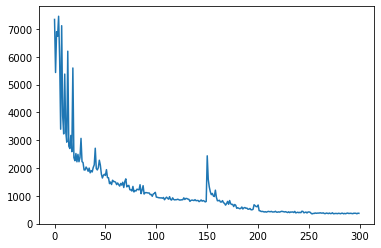

In [20]:
plt.plot(np.array(validation)[:,0])

In [23]:
elapsed_time.mean()/1000


26.72294771484375